In [1]:
""" Imports """ 
from ultralytics import YOLO
from IPython.display import display, Image, HTML
import matplotlib.pyplot as plt
from roboflow import Roboflow
from moviepy.editor import VideoFileClip
from IPython.display import Video
import os
import cv2
import random
import numpy as np
import glob
from IPython.display import HTML
from base64 import b64encode

# Step 1: Data preparation

 ## Import workspace from Roboflow

    ### Pistols

In [2]:
rf = Roboflow(api_key="uwb0IGQ9qylr3qgFDdhv")
project = rf.workspace("aitechproject").project("weapon-detection-guns")
dataset = project.version(1).download("yolov8")

    ### Knifes

In [3]:
rf = Roboflow(api_key="uwb0IGQ9qylr3qgFDdhv")
project = rf.workspace("aitechproject").project("weapon-detection-knifes")
dataset = project.version(1).download("yolov8")

In [3]:
# work directory
HOME = os.getcwd()
dataset_location = "weapon-detection-guns-knifes-1"

## Data visualization with bboxes

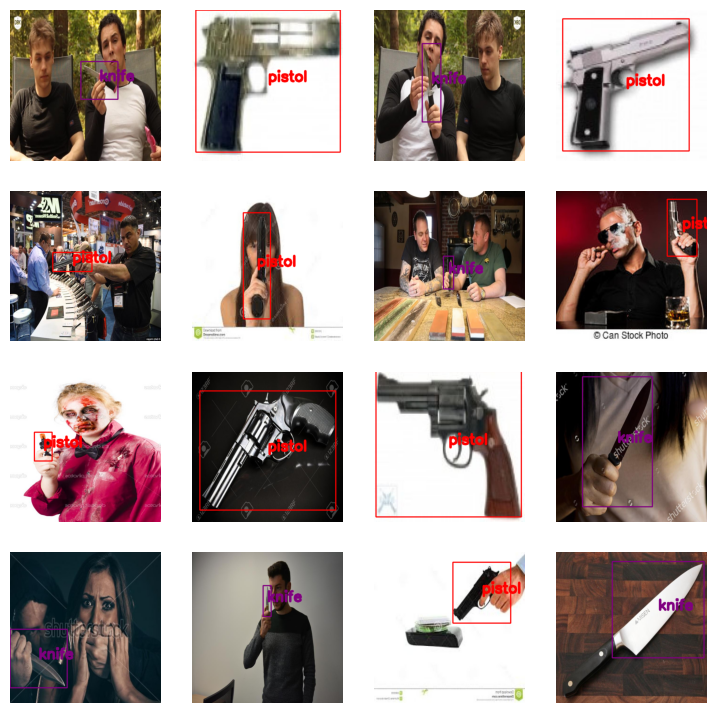

In [33]:
plt.figure(figsize = (9, 9))
plt.tight_layout()

images_path = f'{dataset_location}/train/images'
images_list = os.listdir(images_path)

labels_path = f'{dataset_location}/train/labels'
labels_list = os.listdir(labels_path)

random_range = random.sample(range(len(images_list)), 16)

for counter, random_index in enumerate(random_range, 1):

    selected_image = images_list[random_index]
    
    img_path = os.path.join(images_path, selected_image)
    label_path = os.path.join(labels_path, selected_image[:-4] + '.txt')

    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_h, img_w = img.shape[:2]

    with open(label_path, 'r') as file:
        for line in file:
            
            obj_inf = line.split()
            class_name, centerX, centerY, width, height = obj_inf
            weapon, color = ('knife',(128, 0, 128)) if class_name == '0' else ('pistol',(255, 0, 0))

            centerX = float(centerX)
            centerY = float(centerY)
            width = float(width)
            height = float(height)

            x1 = int((centerX-width/2)*img_w)
            y1 = int((centerY-height/2)*img_h)
            x2 = int((centerX+width/2)*img_w)
            y2 = int((centerY+height/2)*img_h)

            cv2.rectangle(img, (x1, y1),(x2, y2), color, 3)

            centerX = int(centerX*img_w)
            centerY = int(centerY*img_h)
            cv2.putText(img, weapon, (centerX, centerY),cv2.FONT_HERSHEY_SIMPLEX, 2, color, 10)

    
    # Display the frame.
    plt.subplot(4, 4, counter);plt.imshow(img);plt.axis('off')

# Step 2: Training using YOLOV8

In [4]:
# Loading pre-trained weights
model = YOLO('yolov8s.pt')
results = model.train(data=dataset_location+'/'+'data.yaml', epochs=100)

Ultralytics YOLOv8.0.134 🚀 Python-3.9.12 torch-2.0.1+cu117 CUDA:0 (NVIDIA GeForce RTX 2080 Ti, 11019MiB)
yolo/engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=weapon-detection-guns-knifes-1/data.yaml, epochs=100, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False, op

# Step 3: Predictions

In [4]:
""" Loading trained model """
model_path = os.path.join('.', 'runs', 'detect', 'train2', 'weights', 'best.pt')
model = YOLO(model_path)

### predict on images

In [14]:
test_images_path = os.path.join(dataset_location, "test", "images")
results = model.predict(source=test_images_path, conf=0.25, save=True, show_conf=True)

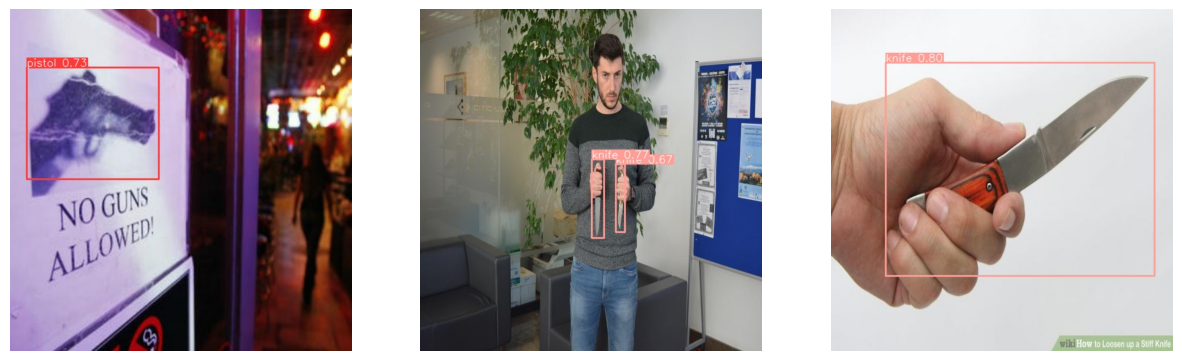

In [25]:
plt.figure(figsize = (15, 15))
plt.tight_layout()

images_path = f'{HOME}/runs/detect/predict2'
images_list = os.listdir(images_path)

random_range = random.sample(range(len(images_list)), 3)

for counter, random_index in enumerate(random_range, 1):

    selected_image = images_list[random_index]
    
    img_path = os.path.join(images_path, selected_image)

    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_h, img_w = img.shape[:2]

    # Display the frame.
    plt.subplot(1, 3, counter);plt.imshow(img);plt.axis('off')

### predict on videos

In [11]:
movie_path = os.path.join("project_databases", "movies", "W_2.mp4")
results = model.predict(source=movie_path, conf=0.65, save=True, show_conf=True, save_crop=True, verbose=False, stream=True)

In [9]:
# Save the predicted video in web format
saved_dir = results.__getitem__(0).save_dir
vid_path  = results.__getitem__(0).path
vid_dir, full_vid_name = os.path.split(vid_path)
vid_name, extension = os.path.splitext(full_vid_name)


def convert_avi_to_webm(input_file, output_file):
    # Load the AVI video clip
    clip = VideoFileClip(input_file)

    # Write the video clip to WebM format
    clip.write_videofile(output_file) #codec="libvpx", audio_codec="libvorbis" [for webm]


input_avi = os.path.join(saved_dir, vid_name+'.avi')
output_webm = os.path.join(saved_dir, vid_name+'.mp4')
convert_avi_to_webm(input_avi, output_webm)

Moviepy - Building video runs/detect/predict2/W_2.mp4.
Moviepy - Writing video runs/detect/predict2/W_2.mp4



Moviepy - Done !
Moviepy - video ready runs/detect/predict2/W_2.mp4


In [2]:
# To Show a Video in Notebook
def Play_Video(filepath):
    html = ''
    video = open(filepath,'rb').read()
    src = 'data:video/mp4;base64,' + b64encode(video).decode()
    html += '<video width=640 muted controls autoplay loop><source src="%s" type="video/mp4"></video>' % src 
    return HTML(html)

In [10]:
Play_Video("./runs/detect/predict2/W_2.mp4")